In [1]:
# TradingEnv.py
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt 

import yfinance as yf

#from pybroker import YFinance
#import pybroker
#pybroker.enable_data_source_cache('yfinance')
from stable_baselines3 import PPO

In [2]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['date']
        self.stock_price_history = data['adj_close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost
        
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  # (Action, Amount) where Action: -1: Buy, 0: Hold, 1: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))
        
        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance
        
    def reset(self, seed = None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}
    
    def step(self, action):
        assert self.action_space.contains(action)
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]    
        amount = int(self.initial_balance * action[1] / current_price)
    
        if action[0] > 0:  # Buy
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  # Sell
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)
        
        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value 
        risk_free_rate = 0.02  # Example risk-free rate
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0
        reward = sharpe_ratio
         
        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()
        
        self.current_step += 1
        
        if self.current_step == len(self.data['adj_close']):
            done = True
        else:
            done = False
        
        self.done = done

        info = {}  
        return obs, reward, done, False,info
    
    
    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])
    
    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]
        
        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)
    
    def render_all(self):
        df = self.render_df.set_index('Date')       
        fig, ax = plt.subplots(figsize=(18, 6)) 
        df.plot( y="market_value" , use_index=True,  ax = ax, style='--' , color='lightgrey') 
        df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black')
         
        for idx in df.index.tolist():
            if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] - 1,
                    'g^'
                )
                plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
            elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] + 1,
                    'rv'
                    )
                plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center')        

In [3]:
df_train = yf.download("MSFT", start="2024-10-16", end="2024-11-13", interval='15m')

df_train.columns = df_train.columns.droplevel(1)
df_train.reset_index(inplace=True)

df_train = df_train.rename(columns={"Datetime": "date", "Adj Close": "adj_close"})

[*********************100%***********************]  1 of 1 completed


In [4]:
display(df_train)

Price,date,adj_close,Close,High,Low,Open,Volume
0,2024-10-16 09:30:00,413.390015,413.390015,415.839996,413.209991,415.019989,1590443
1,2024-10-16 09:45:00,410.929993,410.929993,414.109985,410.640808,413.410004,1048877
2,2024-10-16 10:00:00,412.734985,412.734985,412.839996,410.480011,410.880005,815615
3,2024-10-16 10:15:00,413.329987,413.329987,413.440002,411.929993,412.732788,489726
4,2024-10-16 10:30:00,412.640015,412.640015,413.500000,412.345001,413.299988,466166
...,...,...,...,...,...,...,...
515,2024-11-12 14:45:00,423.709991,423.709991,423.839996,423.079987,423.282501,292904
516,2024-11-12 15:00:00,424.007690,424.007690,424.439911,423.630096,423.739990,369294
517,2024-11-12 15:15:00,423.552002,423.552002,424.049988,423.300293,423.950012,558675
518,2024-11-12 15:30:00,423.378693,423.378693,423.529999,423.019989,423.489990,432044


In [5]:
env_train = StockTradingEnv(df_train, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

In [7]:
model = PPO("MlpPolicy", env_train, verbose=0)
model.learn(total_timesteps=100_000, progress_bar=True)
#model.save("ppo_aapl")

Output()

In [8]:
display(env_train.render_df)

,Date,market_value,balance,stock_owned,price,action,amount
0,2024-10-16 09:30:00,100000.000000,100000.000000,0,413.390015,sell,0
1,2024-10-16 09:45:00,99683.542813,37633.113919,151,410.929993,buy,151
2,2024-10-16 10:00:00,99956.096707,37633.113919,151,412.734985,buy,91
3,2024-10-16 10:15:00,100045.941891,37633.113919,151,413.329987,buy,0
4,2024-10-16 10:30:00,99941.756131,37633.113919,151,412.640015,buy,0
...,...,...,...,...,...,...,...
100347,2024-11-12 12:45:00,100000.000000,100000.000000,0,419.790009,sell,0
100348,2024-11-12 13:00:00,100000.000000,100000.000000,0,420.700012,sell,0
100349,2024-11-12 13:15:00,100000.000000,100000.000000,0,421.760010,sell,0
100350,2024-11-12 13:30:00,100000.000000,100000.000000,0,422.380005,sell,0


In [9]:
model.save("ppo_msft_v1")

In [10]:
df_test = yf.download("MSFT", start="2024-11-13", end="2024-12-13", interval='15m')

df_test.columns = df_test.columns.droplevel(1)
df_test.reset_index(inplace=True)

df_test = df_test.rename(columns={"Datetime": "date", "Adj Close": "adj_close"})

[*********************100%***********************]  1 of 1 completed


In [11]:
env_test = StockTradingEnv(df_test, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

model = PPO.load("ppo_msft_v1", env=env_test)

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(len(df_test['adj_close'])):
    action, _state = model.predict(obs)
    obs, reward, done, info = vec_env.step(action)

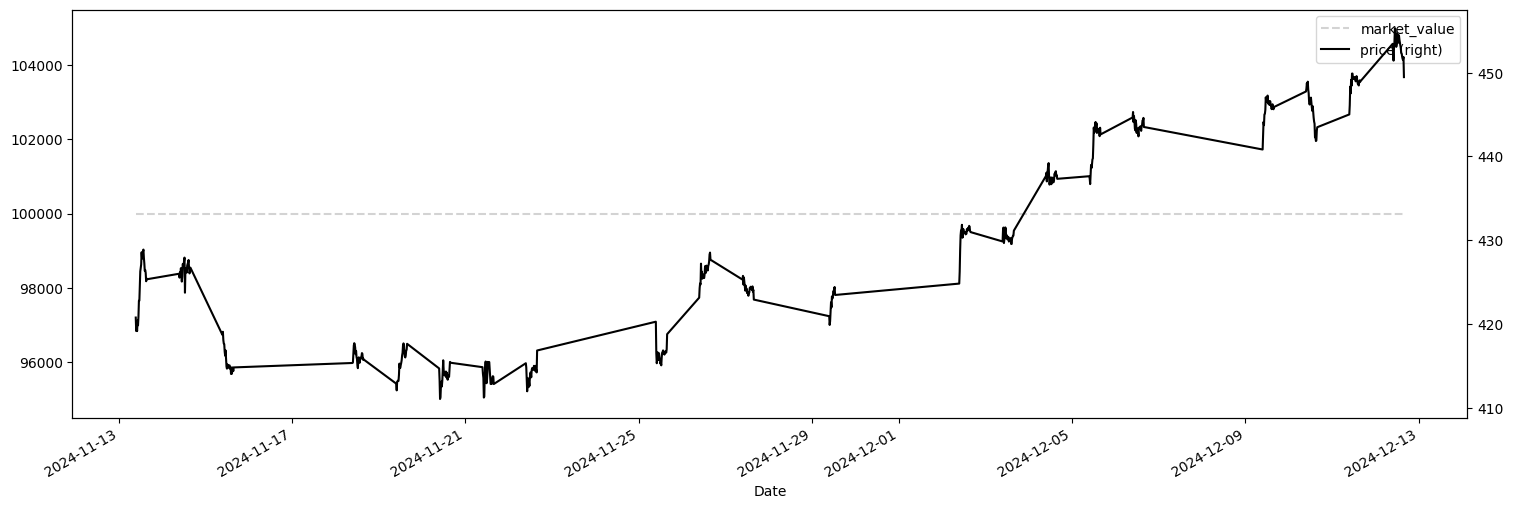

In [12]:
env_test.render_all()